# Learning Outcomes
- Quantum Teleportation 
- Superdense Coding
- Quantum Key Distribution

# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Overview](#overview)    
2. [The Quantum Teleportation Protocol](#how)       
3. [Simulating the Teleportation Protocol](#simulating)   
    3.1 [How will we Test this Result on a Real Quantum Computer?](#testing)   
    3.2 [Using the Statevector Simulator](#simulating-sv)     
    3.3 [Using the QASM Simulator](#simulating-qs)  
4. [Understanding Quantum Teleportation](#understanding-qt)
5. [Teleportation on a Real Quantum Computer](#real_qc)    
    5.1 [IBM hardware and Deferred Measurement](#deferred-measurement)    
    5.2 [Executing](#executing)    
6. [References](#references)



## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol <a id='how'></a>
To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

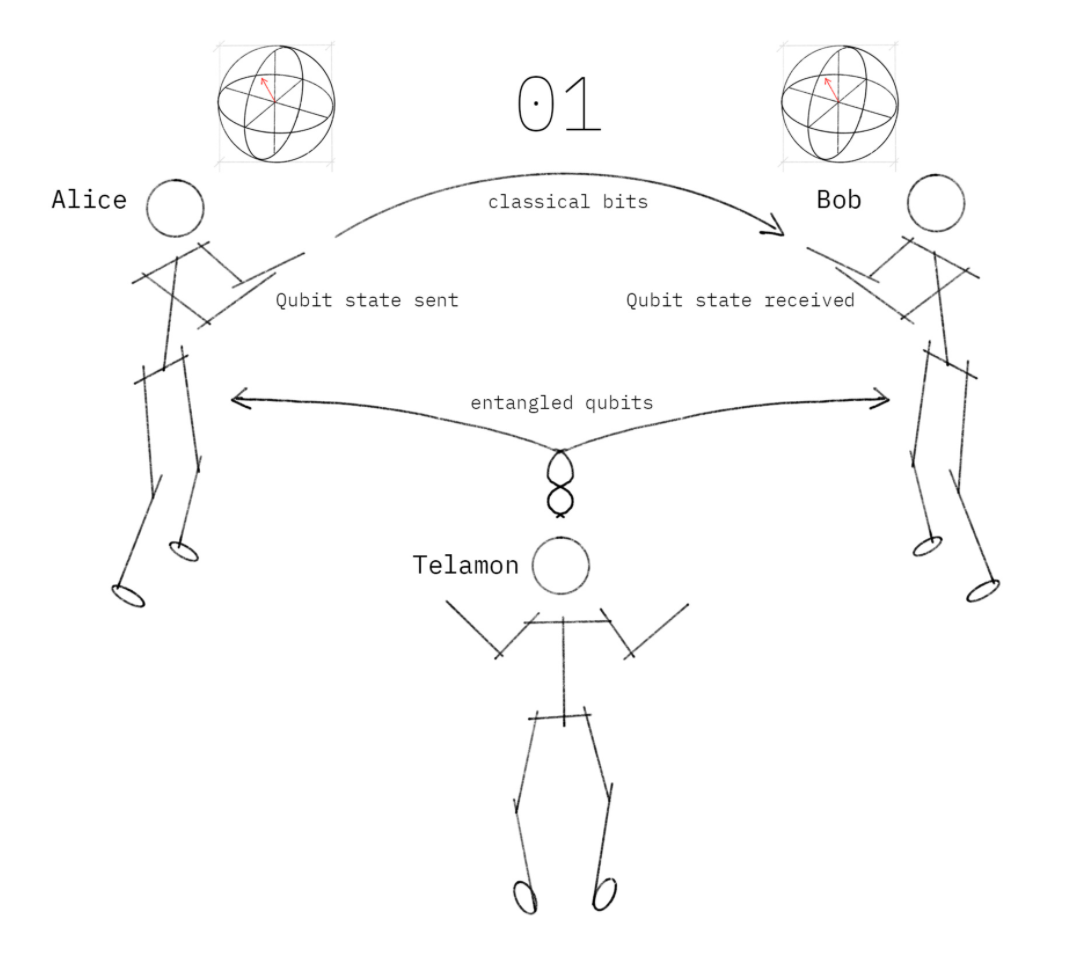

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [25]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

and create our quantum circuit:

In [26]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [27]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

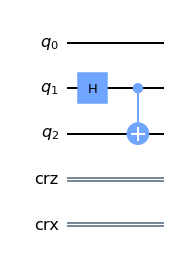

In [28]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [29]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

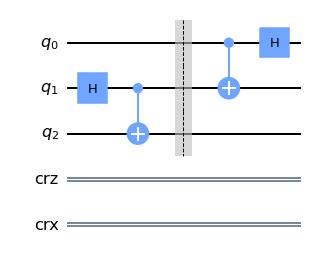

In [30]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [31]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

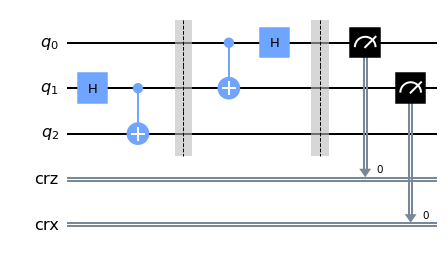

In [32]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [33]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

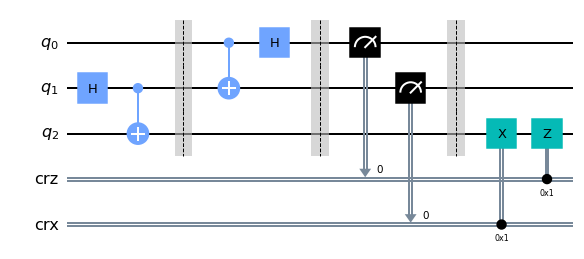

In [34]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

### 3.1 How Will We Test the Protocol on a Quantum Computer? <a id='testing'></a>

In this notebook, we will initialize Alice's qubit in a random state $\vert\psi\rangle$ (`psi`). This state will be created using an `Initialize` gate on $|q_0\rangle$. In this chapter we use the function `random_state` to choose `psi` for us, but feel free to set `psi` to any qubit state you want.

<IPython.core.display.Math object>

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


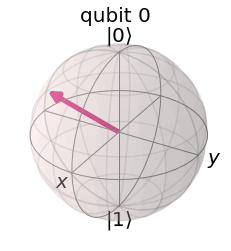

In [35]:
# Create random 1-qubit state
np.random.seed(0)
psi = random_state(1)

# Display it nicely
array_to_latex(psi, pretext="|\\psi\\rangle =")
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$:

In [12]:
init_gate = Initialize(psi)
init_gate.label = "init"

### Exercise 1

Let's say the state $$|\phi\rangle = \begin{bmatrix} a_0 + ia_1 \\ b_0 \end{bmatrix} $$ is orthogonal to state $|\psi\rangle $ we defined above. In order to find the values for $a_0,a_1$ and $b_0$ we need three linearly independent equations. Solving them can be a lot of work, so I just want you to write down three linearly independent equations. In other words, what are the conditions for $|\phi\rangle$ to be a normalized and an orthogonal state to $|\psi\rangle$?

### Answer

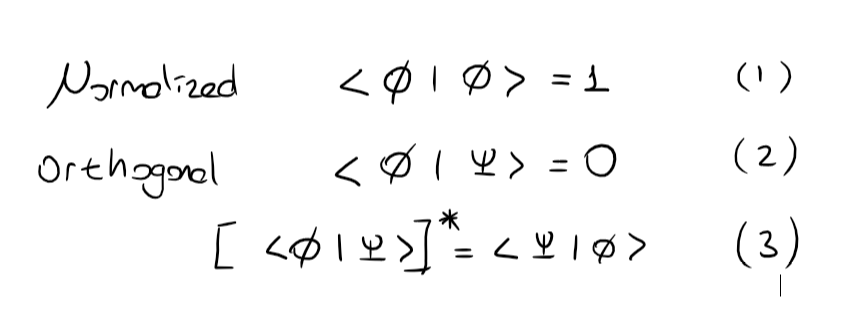

(`Initialize` is technically not a gate since it contains a reset operation, and so is not reversible. We call it an 'instruction' instead). If the quantum teleportation circuit works, then at the end of the circuit the qubit $|q_2\rangle$ will be in this state. We will check this using the statevector simulator.

### 3.2 Using the Statevector Simulator <a id='simulating-sv'></a>

We can use the statevector simulator to verify our qubit has been teleported.

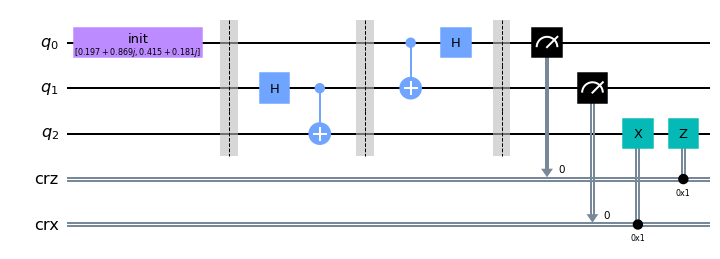

In [13]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

We can see below, using our statevector simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


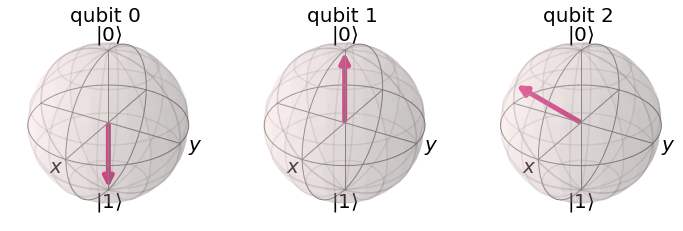

In [14]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

You can run this cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state $|\psi\rangle$.

### 3.3 Using the QASM Simulator <a id='simulating-qs'></a>

Quantum teleportation is designed to send qubits between two parties. We do not have the hardware to demonstrate this, but we can demonstrate that the gates perform the correct transformations on a single quantum chip. Here we use the QASM simulator to simulate how we might test our protocol.

On a real quantum computer, we would not be able to sample the statevector, so if we wanted to check our teleportation circuit is working, we need to do things slightly differently. The `Initialize` instruction first performs a reset, setting our qubit to the state $|0\rangle$. It then applies gates to turn our $|0\rangle$ qubit into the state $|\psi\rangle$:

$$ |0\rangle \xrightarrow{\text{Initialize gates}} |\psi\rangle $$

Since all quantum gates are reversible, we can find the inverse of these gates using:

In [15]:
inverse_init_gate = init_gate.gates_to_uncompute()

This operation has the property:

$$ |\psi\rangle \xrightarrow{\text{Inverse Initialize gates}} |0\rangle $$

To prove the qubit $|q_0\rangle$ has been teleported to $|q_2\rangle$, if we do this inverse initialization on $|q_2\rangle$, we expect to measure $|0\rangle$ with certainty. We do this in the circuit below:

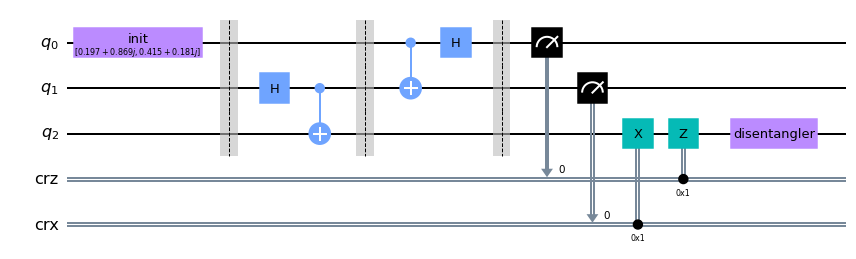

In [16]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

We can see the `inverse_init_gate` appearing, labelled 'disentangler' on the circuit diagram. Finally, we measure the third qubit and store the result in the third classical bit:

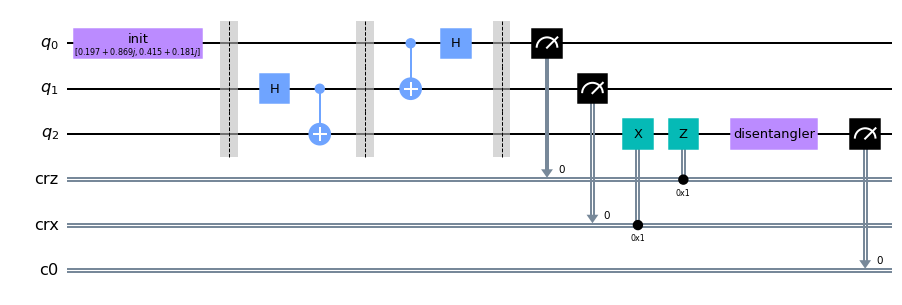

In [17]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

and we run our experiment:

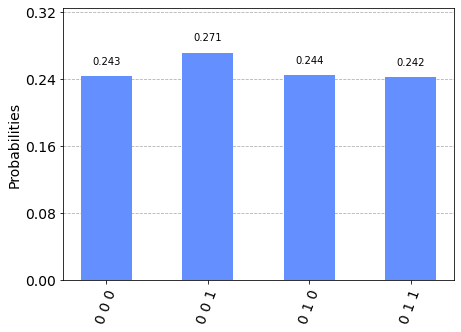

In [18]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

We can see we have a 100% chance of measuring $q_2$ (the leftmost bit in the string) in the state $|0\rangle$. This is the expected result, and indicates the teleportation protocol has worked properly.

## 4. Understanding Quantum Teleportation <a id="understanding-qt">

As you have worked with the Quantum Teleportation's implementation, it is time to understand the mathematics behind the protocol.

#### Step 1

Quantum Teleportation begins with the fact that Alice needs to transmit $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ (a random qubit) to Bob. She doesn't know the state of the qubit. For this, Alice and Bob take the help of a third party (Telamon). Telamon prepares a pair of entangled qubits for Alice and Bob. The entangled qubits could be written in Dirac Notation as:

$$ |e \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively),

$$|e\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B) $$

This creates a three qubit quantum system where Alice has the first two qubits and Bob the last one.

$$ \begin{align*}
|\psi\rangle \otimes |e\rangle &= \frac{1}{\sqrt{2}} (\alpha |0\rangle \otimes (|00\rangle + |11\rangle) + \beta |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) 
\end{align*}$$

### Exercise 2

Let's say Telamon is unavailable, instead his son Ajax is. But Ajax can only prepare entangled qubits in the following Bell state:

$$ |d \rangle =  \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle) $$

- Design the circuit for initializing this state.
- Write down $|\psi\rangle \otimes | d \rangle $.

### Answer



In [19]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [20]:
#This circuit will initilize the s
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.h(0)
qc.x(0)
qc.x(1)
qc.z(0)

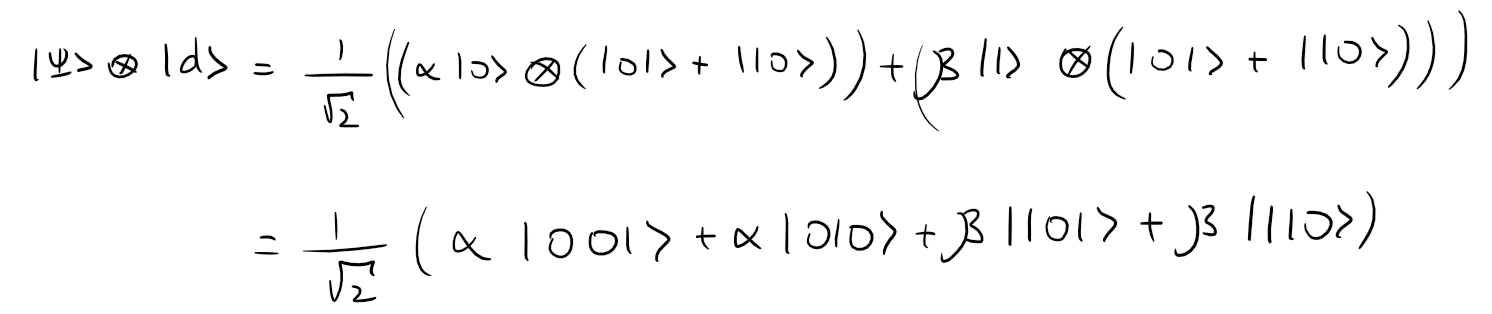

#### Step 2

Now according to the protocol Alice applies CNOT gate on her two qubits followed by Hadamard gate on the first qubit. This results in the state:

$$ 
\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|\psi\rangle \otimes |e\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|110\rangle + \beta|101\rangle) \\
&= \frac{1}{2}  (\alpha(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}
$$

Which can then be separated and written as: 

$$
\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (\alpha|0\rangle + \beta|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (\alpha|1\rangle + \beta|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (\alpha|0\rangle - \beta|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (\alpha|1\rangle - \beta|0\rangle) \quad )\\
\end{align*}
$$

### Exercise 3

In order to use the entangled qubits produced by Ajax to perform quantum teleportation we must modify our protocol. According to the new protocol, Alice will apply a C0NOT gate to her two qubits followed by a Hadamard gate.

- Explicitly write down $ (H \otimes I \otimes I) (CNOT \otimes I) (|\psi\rangle \otimes |e\rangle)  $
- Decompose the resulted state like the one above. That is $|00\rangle \otimes (\text{sth})$ for 00,01,10 and 11.

### Answer

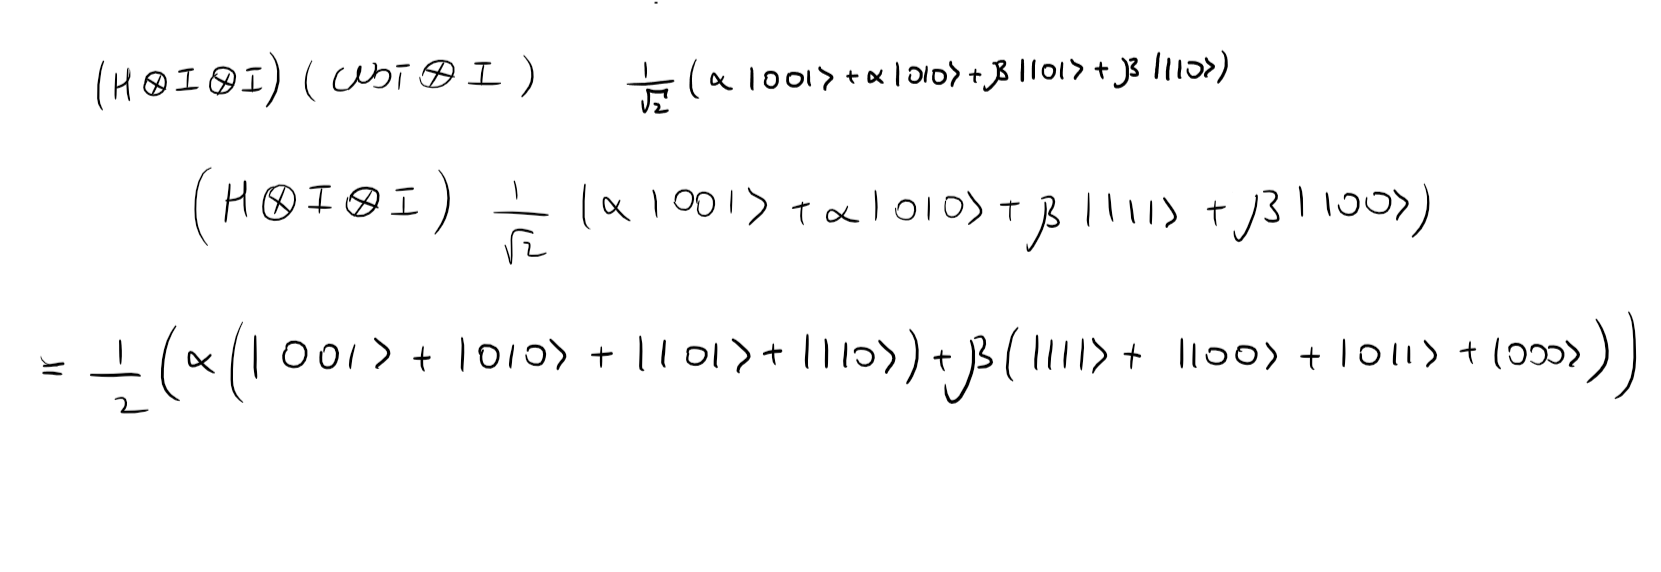

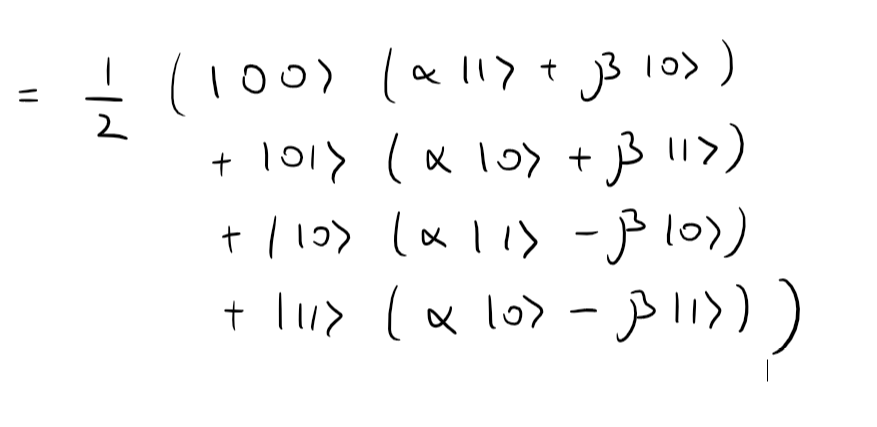

# Step 4

Bob, on receiving the bits from Alice, knows he can obtain the original state $|\psi\rangle$ by applying appropriate transformations on his qubit that was once part of the entangled pair.

The transformations he needs to apply are:

$$
\begin{array}{c c c}
\mbox{Bob's State}                 & \mbox{Bits Received} & \mbox{Gate Applied} \\
(\alpha|0\rangle + \beta|1\rangle) & 00                   & I                   \\
(\alpha|1\rangle + \beta|0\rangle) & 01                   & X                   \\
(\alpha|0\rangle - \beta|1\rangle) & 10                   & Z                   \\
(\alpha|1\rangle - \beta|0\rangle) & 11                   & ZX
\end{array}
$$

After this step Bob will have successfully reconstructed Alice's state.

### Exercise 4

Which gates should Bob apply to his qubit to successfully reconstruct Alice's state? Fill in the table below according to your results from Exercise 3.

$$
\begin{array}{c c c}
\mbox{Bob's State}                 & \mbox{Bits Received} & \mbox{Gate Applied} \\
 & 00                   &                    \\
 & 01                   &                    \\
 & 10                   &                    \\
 & 11                   & 
\end{array}
$$

### Answer

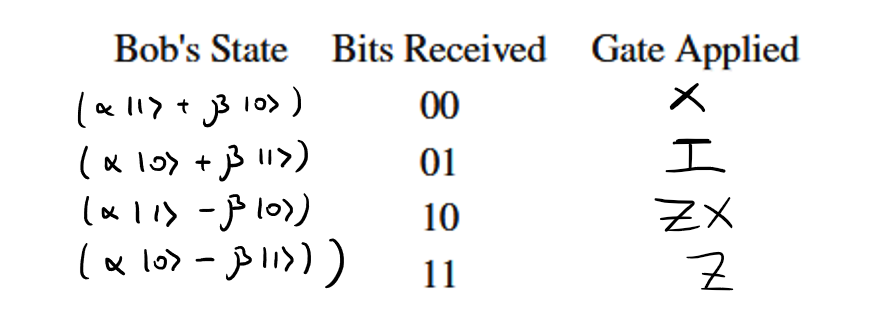

## 5. Teleportation on a Real Quantum Computer <a id='real_qc'></a>

### 5.1 IBM hardware and Deferred Measurement <a id='deferred-measurement'></a>

The IBM quantum computers currently do not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form on real hardware. Fortunately, this does not limit our ability to perform any computations due to the _deferred measurement principle_ discussed in chapter 4.4 of [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

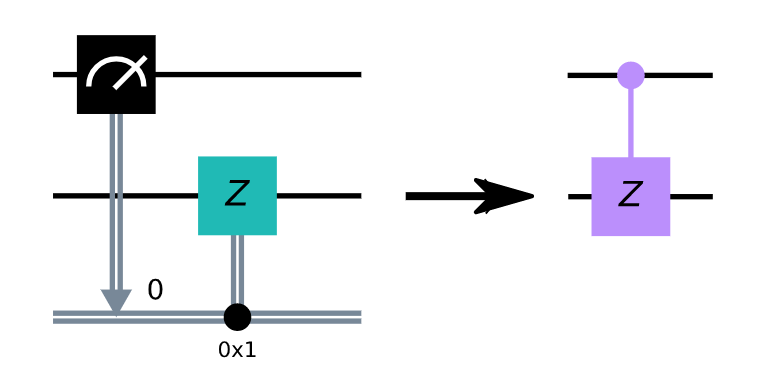

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

Let us re-write the `bob_gates` function to `new_bob_gates`:

In [21]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

And create our new circuit:

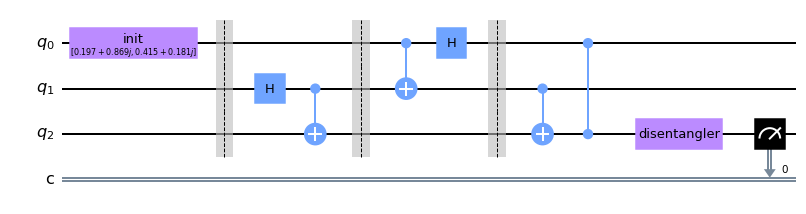

In [22]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

### 5.2 Executing <a id='executing'></a> 

In [23]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

ibmqfactory.load_account:WARNING:2021-05-30 20:49:04,822: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

<ipython-input-24-9873ace37c62>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


{'0': 914, '1': 110}


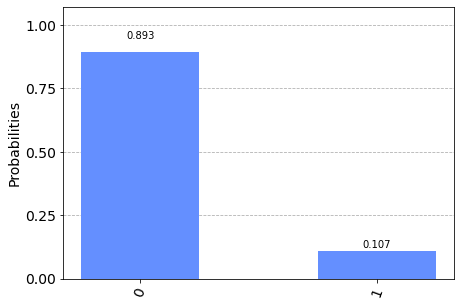

In [25]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

As we see here, there are a few results in which we measured $|1\rangle$. These arise due to errors in the gates and the qubits. In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [26]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")

The experimental error rate : 0.107%


### Exercise 5

Now that all theoretical work for using Ajax's entangled pairs is completed, let's try it with a real quantum computer! Complete the below parts and run the next cell and see if you have done it correctly!

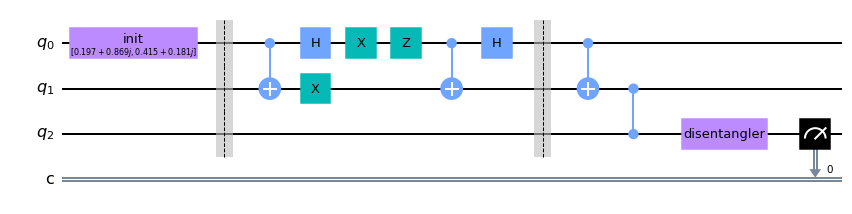

In [37]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
# We don't need to change this part!
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
# Initialize 1st and 2nd qubit to |phi> = 1/sqrt(2) * (|01> + |10>)
# Your code here!

qc.cx(0,1)
qc.h(0)
qc.x(0)
qc.x(1)
qc.z(0)
# Send q1 to Alice and q2 to Bob
# You don't need to change this part.
qc.cx(0,1)
qc.h(0)
qc.barrier()

# Alice sends classical bits to Bob
# This is the part where we Bob applies the transformations you found in Exercise 4. 
# If you need to apply Y gate if a specific classical bit is 1, you can achieve the 
# same effect by applying a CY gate where the control qubit is qubit 1, for classical bit 1.
qc.cx(0, 1)
qc.cz(1, 2)


# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

In [38]:
# First run this cell to test your code!
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)  # displays job status under cell

ibmqfactory.load_account:WARNING:2021-05-30 21:04:39,967: Credentials are already in use. The existing account in the session will be replaced.
<ipython-input-38-c6d61ed49952>:12: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


{'0': 822, '1': 202}


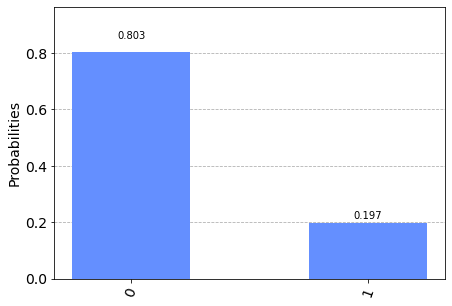

In [39]:
# Then this cell !
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)
# If you get mostly 0, that means you did it correctly!!!

# Superdense Coding

This notebook demonstrates the Superdense Coding (SDC) protocol. We first use Qiskit's simulator to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Superdense Coding and Quantum Teleportation](#difference)
2. [The Process](#process)    
    2.1 [Step 1](#step1)    
    2.2 [Step 2](#step2)    
    2.3 [Step 3](#step3)
3. [Simulating the Superdense Coding Protocol](#simulating)    
    3.1 [3.1 Visualizing Our Measurements](#visualising)    
4. [Superdense Coding on a Real Quantum Computer](#real_qc)


## 1. The Difference between Superdense Coding and Quantum Teleportation <a id='difference'></a>

Quantum teleportation and superdense coding are closely related, to avoid confusion we need to clarify the difference.

Quantum teleportation is a process by which the state of qubit ($|\psi\rangle$) can be transmitted from one location to another, using two bits of classical communication and a Bell pair. In other words, we can say it is a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of shared entanglement. Superdense coding is a procedure that allows someone to send two classical bits to another party using just a single qubit of communication.

| Teleportation                                     | Superdense Coding                                    |
|:-------------------------------------------------:|:----------------------------------------------------:|
| Transmit one<br>qubit using two<br>classical bits | Transmit two<br>classical bits<br>using one<br>qubit |


The teleportation protocol can be thought of as a flipped version of the superdense coding protocol, in the sense that Alice and Bob merely “swap their equipment.”



## 2. The Process <a id='process'></a>

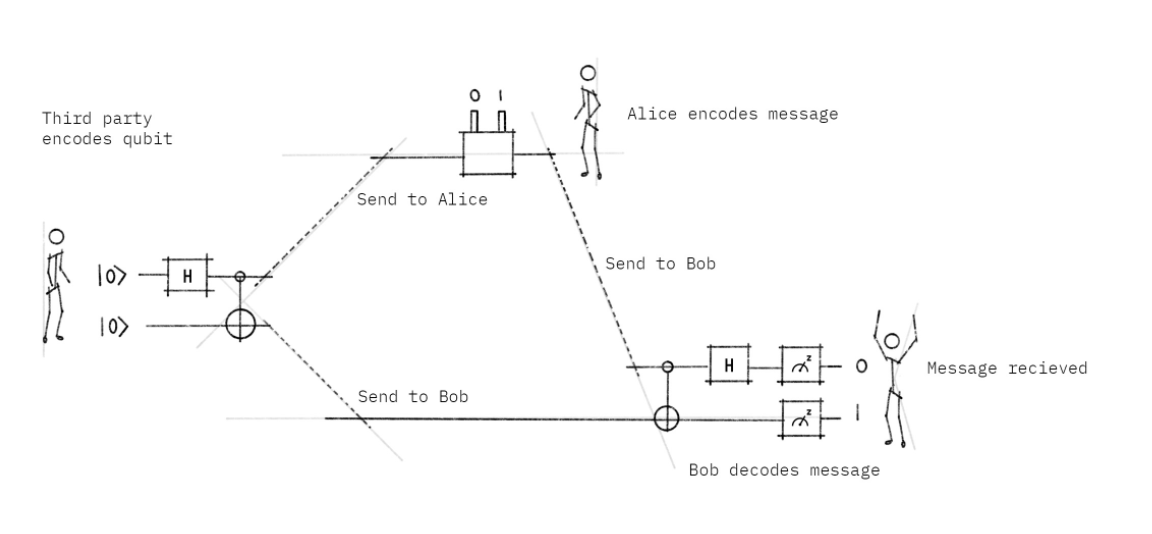

### 2.1 Step 1 <a id='step1'></a>
The process starts with a third party, who we'll call Charlie. Two qubits are prepared by Charlie in an entangled state. He initially starts the 2 qubits in the basis state $|0\rangle$. He applies Hadamard gate ($H$) to the first qubit to create superposition. He then applies CNOT gate ($CX$) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mentioned earlier. 

#### Outcome States

Charlie first applies a Hadamard gate. 

When the H-gate is applied to first qubit, it creates superposition and we get the state:


$$|0+\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$$



Then Charlie applies the CNOT gate. The CNOT gate entangles both qubits, i.e. it flips the target if the control is $|1\rangle$. Note that the control qubit is our rightmost qubit.



$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$





### Exercise 6

Let's say we want to implement a superdense coding protocol but Telamon and Ajax are not available but Ajax's step brother Teucer is. However, Teucer can only prepare the following entangled state:

$$ |f \rangle  = \frac{1}{\sqrt{2}} ( |00\rangle - |11 \rangle ) $$

- Design the circuit for initializing this state.

### Answer



In [ ]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)
qc.z(1)


### 2.2 Step 2 <a id='step2'></a>

Charlie sends the first qubit to Alice and the second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send:


#### Encoding Rules for Superdense Coding (Alice protocol):

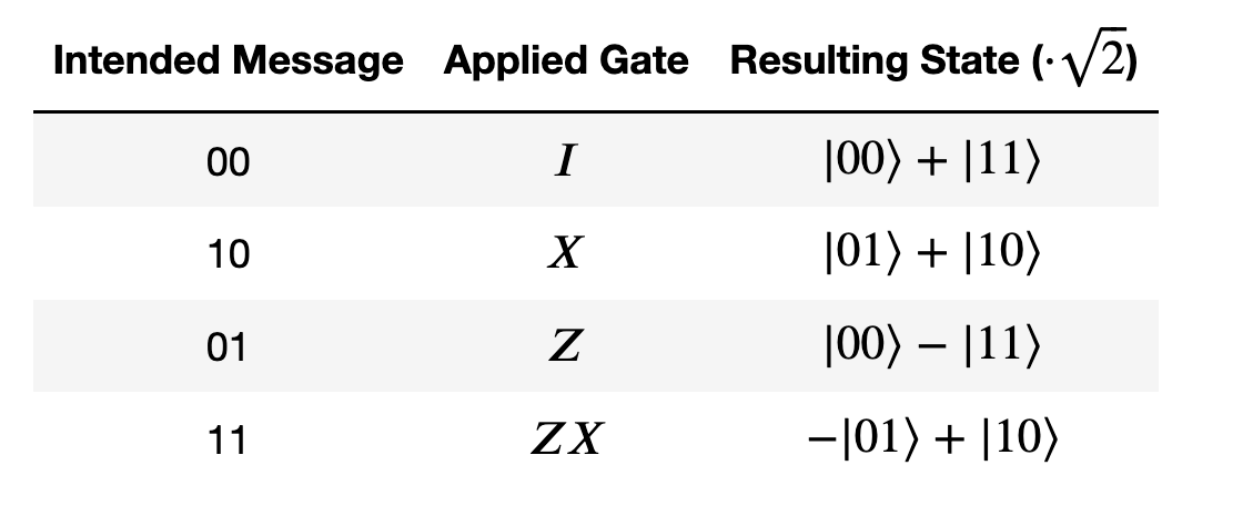


Thus if she wants to send a `00`, she does nothing to her qubit (apply the identity ($I$) gate). If she sends a `10`, then she applies the $X$ gate. Depending on what she wants to send, she applies the appropriate gate, then sends her qubit to Bob for the final step in the process.



### Exercise 7

Let's say Alice does the following operations according to the message she wants to send. Fill in the last column.

|Intended Message:              | Applied Gate:           |  Resulting State($\cdot \sqrt{2})$:  |
|:--------------------------:|:--------------------------:|:---------------:|
| 00  | I  |     |
| 01  | X  |     |
| 10 | Z   |    |
| 11 | XZ  |    |

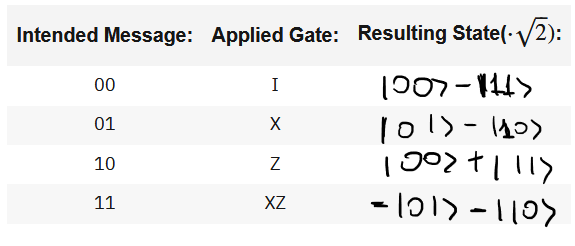


### 2.3 Step 3 <a id='step3'></a>

Bob receives Alice's qubit (rightmost qubit) and uses his qubit to decode Alice's message. Notice that he does not need to have knowledge of the state in order to decode it — he simply uses the restoration operation.

Bob applies a CNOT gate using the rightmost qubit as control and the leftmost as target. Then he applies a Hadamard gate and finally performs a measurement on both qubits to extract Alice's message.

| Bob Receives:              | After CNOT-gate:           |  After H-gate:  |
|:--------------------------:|:--------------------------:|:---------------:|
| $|00\rangle + |11\rangle$  | $|00\rangle + |01\rangle$  |  $|00\rangle$   |
| $|01\rangle + |10\rangle$  | $|11\rangle + |10\rangle$  |  $|10\rangle$   |
| $|00\rangle - |11\rangle$  | $|00\rangle - |01\rangle$  |  $|01\rangle$   |
| $-|01\rangle + |10\rangle$ | $-|11\rangle + |10\rangle$ | $-|11\rangle$   |

When Bob performs the measurements, he is certain to get the message Alice sent him. Note that the last outcome has a negative sign $-|11\rangle$, writing it as $|11\rangle$ is also correct as this is global phase and is not measureable.




### Exercise 8

After Bob receives the state in Exercise 7, he should perform three operations to get the classical message. He should first apply a CNOT gate, then a Hadamard to the first qubit, then a X gate to the first qubit. Fill in the table below to see if this procedure allows Bob to receive the classical message correctly. Note that the first column of the following table should be the last column of the table in Exercise 7!

| Bob Receives:              | After CNOT-gate:           |  After H-gate:  | After X-gate:   | 
|:--------------------------:|:--------------------------:|:---------------:|:---------------:|
|   |  |     |   |
|   |  |     |   |
|   |  |     |   |
|  |  |     |   |


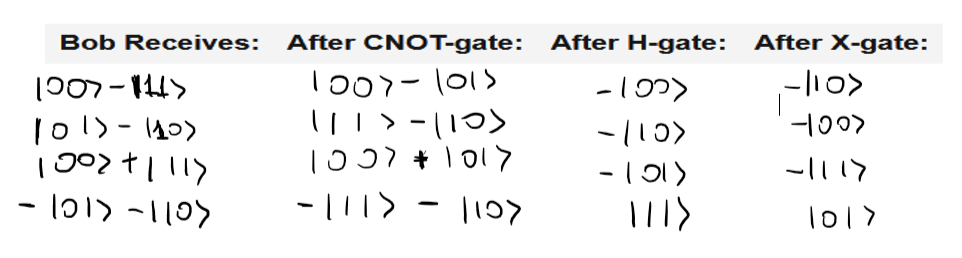

## 3. Simulating the Superdense Coding Protocol <a id='simulating'></a>

In [1]:
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

We saw that to create an entangled pair, we needed to do a H-gate followed by a CNOT. Let's create a function that takes a `QuantumCircuit` and entangles the qubits with indices `a` and `b`:

In [2]:
# Define a function that takes a QuantumCircuit (qc) 
# and two integers (a & b)
def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

Next we need to encode our message. We saw that there were four possible messages we could send: `00`, `10`, `01` or `11`. Let's create a function that takes this message and applies the appropriate gates for us:

In [3]:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

Finally, we need to decode our message, we saw we could do this using a CNOT followed by a H-gate. Let's create a function that does this for us too:

In [4]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

Finally, we can put this together to complete our protocol.

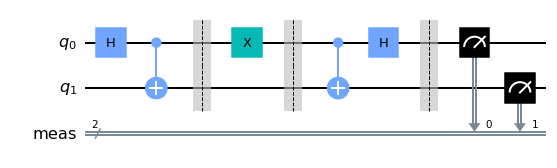

In [5]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

### 3.1 Visualizing Our Measurements <a id='visualising'></a>

{'10': 1024}


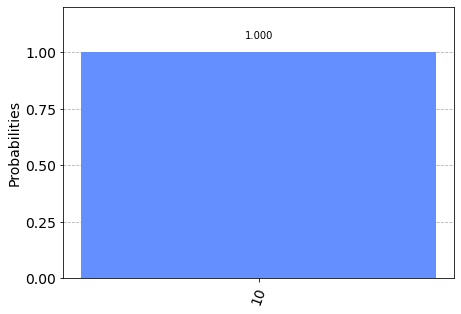

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

Our simulator simulates a perfect quantum computer. We can see that, without errors, we get a 100% chance of measuring the correct message.

## 4. Superdense Coding on a Real Quantum Computer <a id='real_qc'></a>


We can now see this working on a real quantum computer. First, we want to load our account to get the least busy quantum system:

In [7]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)

least busy backend:  ibmqx2


<ipython-input-7-4c5440f57654>:16: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


In [8]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


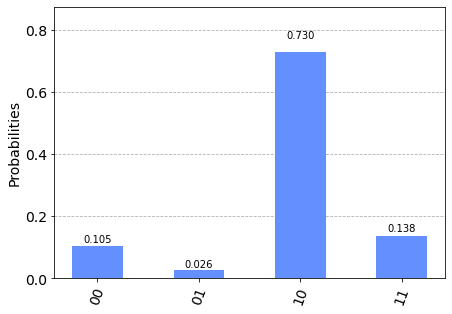

In [9]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

As we see that there are a few results from the other three states when run in a real quantum computer. These are due to errors in the gates and qubit decoherence. We will learn more about these errors in later sections.

In [10]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

Accuracy = 73.05%


### Exercise 9

Now that all theoretical work for using Teucer's entangled pairs is completed, let's try it with a real quantum computer! Complete the below parts and run the next cell and see if you have done it correctly!

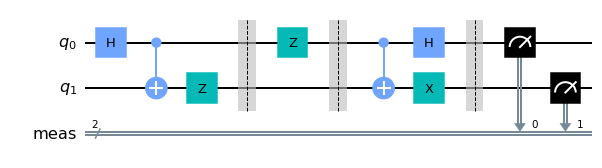

In [23]:
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Teucer creates the entangled pair between Alice and Bob
# Your code for initializing |f> = 1/sqrt(2) * (|00> - |11>) here !!
qc.h(0)
qc.cx(0,1)
qc.z(1)

qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
# You don't need to change this part !!!
message = "10"
if message == "01":
    qc.x(0)
elif message == "10":
    qc.z(0)
elif message == "11":
    qc.z(0)
    qc.x(0)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
# Construct the circuit that applies the receiving protocol decribed in Exercise 8 here !!!
qc.cx(0,1)
qc.h(0)
qc.x(1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()

ibmqfactory.load_account:WARNING:2021-05-31 20:03:28,059: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem


<ipython-input-24-338de7cda6aa>:18: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


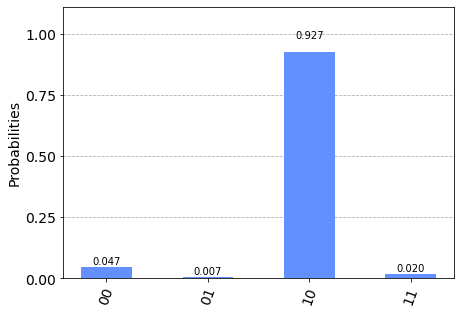

In [24]:
# Run this cell to test your code!!! 

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)

# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

# If the result you obtained is mainly the message you wanted to sent, than you did it correctly.

# Quantum Key Distribution

## Contents

1. Introduction
2. Protocol Overview
3. Qiskit Example: Without Interception
4. Qiskit Example: With Interception
5. Risk Analysis

## 1. Introduction

When Alice and Bob want to communicate a secret message (such as Bob’s online banking details) over an insecure channel (such as the internet), it is essential to encrypt the message. Since cryptography is a large area and almost all of it is outside the scope of this textbook, we will have to believe that Alice and Bob having a secret key that no one else knows is useful and allows them to communicate using symmetric-key cryptography.

If Alice and Bob want to use Eve’s classical communication channel to share their key, it is impossible to tell if Eve has made a copy of this key for herself- they must place complete trust in Eve that she is not listening. If, however, Eve provides a quantum communication channel, Alice and Bob no longer need to trust Eve at all- they will know if she tries to read Bob’s message before it gets to Alice.

For some readers, it may be useful to give an idea of how a quantum channel may be physically implemented. An example of a classical channel could be a telephone line; we send electric signals through the line that represent our message (or bits). A proposed example of a quantum communication channel could be some kind of fibre-optic cable, through which we can send individual photons (particles of light). Photons have a property called _polarisation,_ and this polarisation can be one of two states. We can use this to represent a qubit.


## 2. Protocol Overview  

The protocol makes use of the fact that measuring a qubit can change its state. If Alice sends Bob a qubit, and an eavesdropper (Eve) tries to measure it before Bob does, there is a chance that Eve’s measurement will change the state of the qubit and Bob will not receive the qubit state Alice sent.  

In [56]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
print("Imports Successful")

Imports Successful


If Alice prepares a qubit in the state $|+\rangle$ (`0` in the $X$-basis), and Bob measures it in the $X$-basis, Bob is sure to measure `0`:

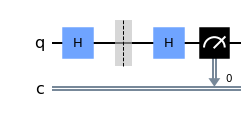

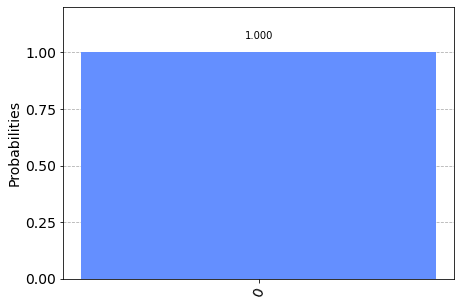

In [57]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

But if Eve tries to measure this qubit in the $Z$-basis before it reaches Bob, she will change the qubit's state from $|+\rangle$ to either $|0\rangle$ or $|1\rangle$, and Bob is no longer certain to measure `0`:

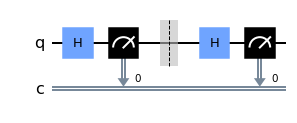

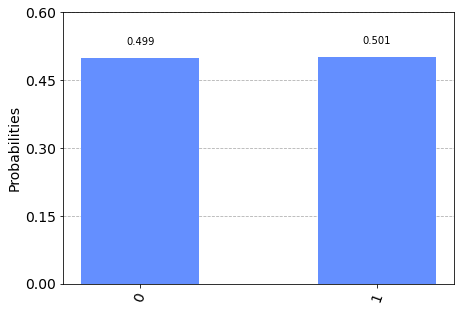

In [58]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
qasm_sim = Aer.get_backend('qasm_simulator')
job = qasm_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

We can see here that Bob now has a 50% chance of measuring `1`, and if he does, he and Alice will know there is something wrong with their channel.

The quantum key distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. It is roughly as follows:

**- Step 1**

Alice chooses a string of random bits, e.g.:

`1000101011010100`

And a random choice of basis for each bit:

`ZZXZXXXZXZXXXXXX`

Alice keeps these two pieces of information private to herself. 

**- Step 2**

Alice then encodes each bit onto a string of qubits using the basis she chose; this means each qubit is in one of the states $|0\rangle$, $|1\rangle$, $|+\rangle$ or $|-\rangle$, chosen at random. In this case, the string of qubits would look like this:

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle|+\rangle|-\rangle|+\rangle|+\rangle
$$

This is the message she sends to Bob.

**- Step 3**

Bob then measures each qubit at random, for example, he might use the bases:

`XZZZXZXZXZXZZZXZ`

And Bob keeps the measurement results private.

**- Step 4**

Bob and Alice then publicly share which basis they used for each qubit. If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

**- Step 5**

Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.


## 3. Qiskit Example: Without Interception

Let’s first see how the protocol works when no one is listening in, then we can see how Alice and Bob are able to detect an eavesdropper. As always, let's start by importing everything we need:

To generate pseudo-random keys, we will use the `randint` function from numpy. To make sure you can reproduce the results on this page, we will set the seed to 0:

In [59]:
np.random.seed(seed=0)

We will call the length of Alice's initial message `n`. In this example, Alice will send a message 100 qubits long:

In [60]:
n = 100

### 3.1 Step 1:

Alice generates her random set of bits:

In [61]:
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


At the moment, the set of bits '`alice_bits`' is only known to Alice. We will keep track of what information is only known to Alice, what information is only known to Bob, and what has been sent over Eve's channel in a table like this:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |       &nbsp;    |

### 3.2 Step 2:

Alice chooses to encode each bit on qubit in the $X$ or $Z$-basis at random, and stores the choice for each qubit in `alice_bases`. In this case, a `0` means "prepare in the $Z$-basis", and a `1` means "prepare in the $X$-basis":

In [62]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


Alice also keeps this knowledge private:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |     &nbsp;      |

The function `encode_message` below, creates a list of `QuantumCircuit`s, each representing a single qubit in Alice's message:

In [63]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [64]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

We can see that the first bit in `alices_bits` is `0`, and the basis she encodes this in is the $X$-basis (represented by `1`):

In [65]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


And if we view the first circuit in `message` (representing the first qubit in Alice's message), we can verify that Alice has prepared a qubit in the state $|+\rangle$:

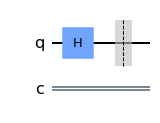

In [66]:
message[0].draw()

As another example, we can see that the fourth bit in `alice_bits` is `1`, and it is encoded in the $Z$-basis, Alice prepares the corresponding qubit in the state $|1\rangle$:

bit = 1
basis = 0


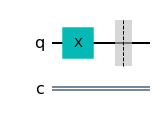

In [67]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw()

This message of qubits is then sent to Bob over Eve's quantum channel:

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |

### 3.3 Step 3:

Bob then measures each qubit in the $X$ or $Z$-basis at random and stores this information:

In [68]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


`bob_bases` stores Bob's choice for which basis he measures each qubit in.

| Alice's Knowledge |Over Eve's Channel| Bob's Knowledge |
|:-----------------:|:----------------:|:---------------:|
|     alice_bits    |                  |                 |
|    alice_bases    |                  |                 |
|      message      |     message      |     message     |
|                   |                  |    bob_bases    |

Below, the function `measure_message` applies the corresponding measurement and simulates the result of measuring each qubit. We store the measurement results in `bob_results`.

In [69]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [70]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

We can see that the circuit in `message[0]` (representing the 0th qubit) has had an $X$-measurement added to it by Bob:

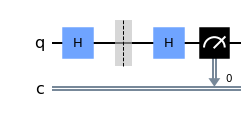

In [71]:
message[0].draw()

Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result `0`. For the 6th qubit (shown below), Bob's random choice of measurement is not the same as Alice's, and Bob's result has only a 50% chance of matching Alices'. 

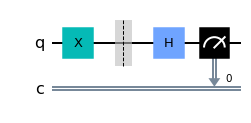

In [72]:
message[6].draw()

In [73]:
print(bob_results)

[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Bob keeps his results private.

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |

### 3.4 Step 4:

After this, Alice reveals (through Eve's channel) which qubits were encoded in which basis: 

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |

And Bob reveals which basis he measured each qubit in:

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |      &nbsp;     |

If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in `bob_results` will match the corresponding entry in `alice_bits`, and they can use that bit as part of their key. If they measured in different bases, Bob's result is random, and they both throw that entry away. Here is a function `remove_garbage` that does this for us:

In [74]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys:

In [75]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     &nbsp;      |

In [76]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |

### 3.5 Step 5:

Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:

In [77]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [78]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |

If the protocol has worked correctly without interference, their samples should match:

In [79]:
bob_sample == alice_sample

True

If their samples match, it means (with high probability) `alice_key == bob_key`. They now share a secret key they can use to encrypt their messages!

| Alice's Knowledge | Over Eve's Channel | Bob's Knowledge |
|:-----------------:|:------------------:|:---------------:|
|     alice_bits    |                    |                 |
|    alice_bases    |                    |                 |
|      message      |       message      |     message     |
|                   |                    |    bob_bases    |
|                   |                    |   bob_results   |
|                   |     alice_bases    |   alice_bases   |
|     bob_bases     |      bob_bases     |                 |
|     alice_key     |                    |     bob_key     |
|     bob_sample    |     bob_sample     |    bob_sample   |
|    alice_sample   |    alice_sample    |   alice_sample  |
|     shared_key    |                    |    shared_key   |

In [80]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## 4. Qiskit Example: *With* Interception

Let’s now see how Alice and Bob can tell if Eve has been trying to listen in on their quantum message. We repeat the same steps as without interference, but before Bob receives his qubits, Eve will try and extract some information from them. Let's set a different seed so we get a specific set of reproducible 'random' results:

In [81]:
np.random.seed(seed=3)

### 4.1 Step 1:

Alice generates her set of random bits:

In [82]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


### 4.2 Step 2:

Alice encodes these in the $Z$ and $X$-bases at random, and sends these to Bob through Eve's quantum channel:

In [83]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


In this case, the first qubit in Alice's message is in the state $|+\rangle$:

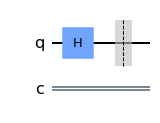

In [84]:
message[0].draw()

### Interception!

Oh no! Eve intercepts the message as it passes through her channel. She tries to measure the qubits in a random selection of bases, in the same way Bob will later.

In [85]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1]


We can see the case of qubit 0 below; Eve's random choice of basis is not the same as Alice's, and this will change the qubit state from $|+\rangle$, to a random state in the $Z$-basis, with 50% probability of $|0\rangle$ or $|1\rangle$:

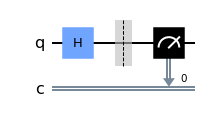

In [86]:
message[0].draw()

### 4.3 Step 3:

Eve then passes on the qubits to Bob, who measures them at random. In this case, Bob chose (by chance) to measure in the same basis Alice prepared the qubit in. Without interception, Bob would be guaranteed to measure `0`, but because Eve tried to read the message he now has a 50% chance of measuring `1` instead.

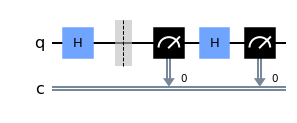

In [87]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw()

### 4.4 Step 4:

Bob and Alice reveal their basis choices, and discard the useless bits:

In [88]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

### 4.5 Step 5:

Bob and Alice compare the same random selection of their keys to see if the qubits were intercepted:

In [89]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [90]:
bob_sample == alice_sample

False

Oh no! Bob's key and Alice's key do not match. We know this is because Eve tried to read the message between steps 2 and 3, and changed the qubits' states. For all Alice and Bob know, this could be due to noise in the channel, but either way they must throw away all their results and try again- Eve's interception attempt has failed.

## 5. Risk Analysis

For this type of interception, in which Eve measures all the qubits, there is a small chance that Bob and Alice's samples could match, and Alice sends her vulnerable message through Eve's channel. Let's calculate that chance and see how risky quantum key distribution is.

- For Alice and Bob to use a qubit's result, they must both have chosen the same basis. If Eve chooses this basis too, she will successfully intercept this bit without introducing any error. There is a 50% chance of this happening.
- If Eve chooses the *wrong* basis, i.e. a different basis to Alice and Bob, there is still a 50% chance Bob will measure the value Alice was trying to send. In this case, the interception also goes undetected.
- But if Eve chooses the *wrong* basis, i.e. a different basis to Alice and Bob, there is a 50% chance Bob will not measure the value Alice was trying to send, and this *will* introduce an error into their keys.

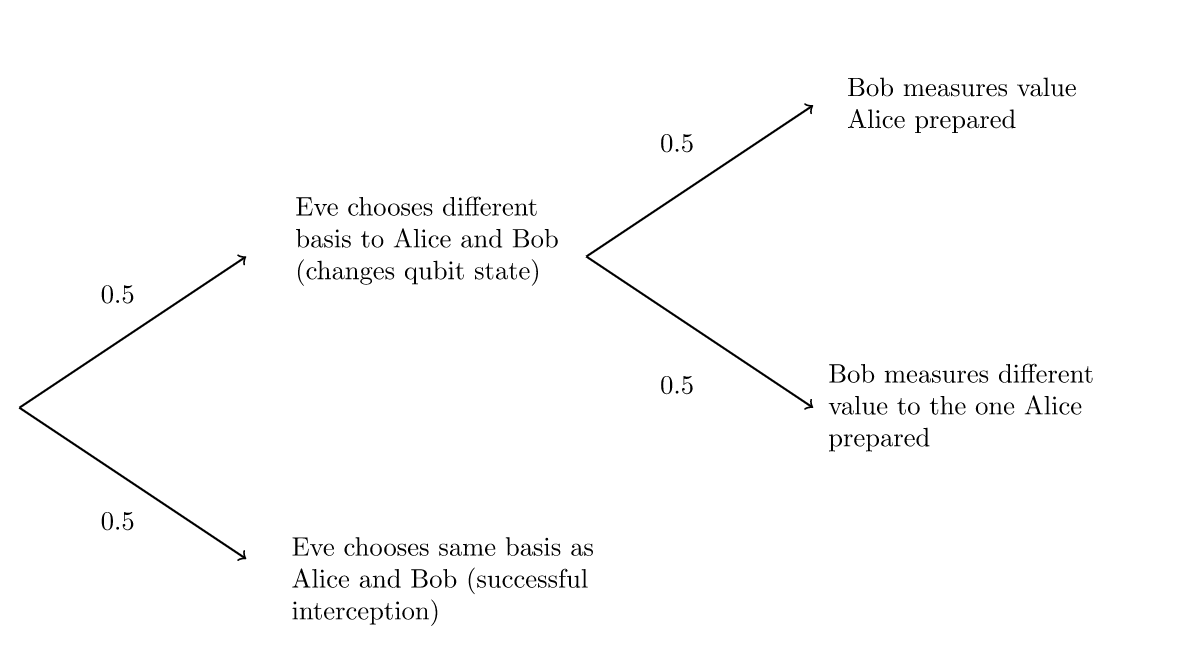

If Alice and Bob compare 1 bit from their keys, the probability the bits will match is $0.75$, and if so they will not notice Eve's interception. If they measure 2 bits, there is a $0.75^2 = 0.5625$ chance of the interception not being noticed. We can see that the probability of Eve going undetected can be calculated from the number of bits ($x$) Alice and Bob chose to compare:

$$ P(\text{undetected}) = 0.75^x $$

If we decide to compare 15 bits as we did above, there is a 1.3% chance Eve will be undetected. If this is too risky for us, we could compare 50 bits instead, and have a 0.00006% chance of being spied upon unknowingly.

You can retry the protocol again by running the cell below. Try changing `sample_size` to something low and see how easy it is for Eve to intercept Alice and Bob's keys.

In [114]:
trials = 1000
undetected = 0.0
for _ in range(trials):
    n = 100
    # Step 1
    alice_bits = randint(2, size=n)
    alice_bases = randint(2, size=n)
    # Step 2
    message = encode_message(alice_bits, alice_bases)
    # Interception!
    eve_bases = randint(2, size=n)
    intercepted_message = measure_message(message, eve_bases)
    # Step 3
    bob_bases = randint(2, size=n)
    bob_results = measure_message(message, bob_bases)
    # Step 4
    bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
    alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
    # Step 5
    sample_size = 15 # Change this to something lower and see if 
                     # Eve can intercept the message without Alice
                     # and Bob finding out
    bit_selection = randint(n, size=sample_size)
    bob_sample = sample_bits(bob_key, bit_selection)
    alice_sample = sample_bits(alice_key, bit_selection)

    if bob_sample != alice_sample:
        #print("Eve's interference was detected.")
        pass
    else:
        undetected += 1
        #print("Eve went undetected!")
print("Eve's interference was undetected %" + str(undetected/trials*100) + " of the time.")

Eve's interference was undetected %0.2 of the time.


### Exercise 10 

There is nothing unique with X or Z basis states while we are trying to perform a Quantum Key distribution. Let's say instead of $|0\rangle, |1\rangle$ set we use $|R \rangle, |L \rangle$ which we define as:
$$ |R \rangle = \frac{|0\rangle + i|1 \rangle}{\sqrt{2}} $$
$$ |L \rangle = \frac{|0\rangle - i|1 \rangle}{\sqrt{2}} $$

Instead of $|+ \rangle, |- \rangle$ we use $|U \rangle, |D \rangle$ which we define as:
$$ |U \rangle = 0.92387953|0\rangle + 0.38268343|1 \rangle $$
$$ |D \rangle = -0.38268343|0\rangle + 0.92387953|1 \rangle $$

- Plot $|R\rangle, |L\rangle, |U\rangle, |D\rangle$ states on the Bloch sphere using the cell below.
- Design the circuit for preparing these states.
- Design the circuits for performing measurement in these states.

### Answer



/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


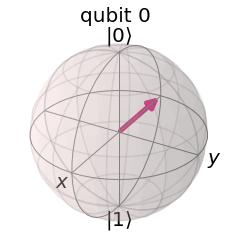

In [41]:
# R
out_vectorR = [1/(2**0.5), (-1**0.5)*1/(2**0.5)]
plot_bloch_multivector(out_vectorR)

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


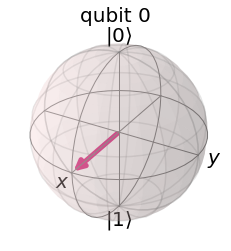

In [39]:
#L
out_vector = [1/(2**0.5), -(-1**0.5)*1/(2**0.5)]
plot_bloch_multivector(out_vector)

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


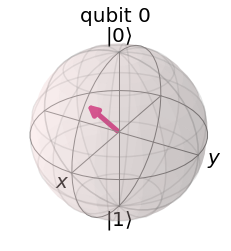

In [24]:
#U
out_vectorU = [0.92387953, 0.38268343]
plot_bloch_multivector(out_vectorU)

/opt/conda/lib/python3.8/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


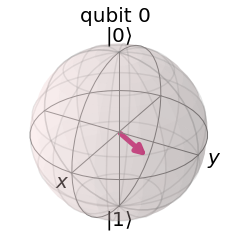

In [23]:
#D
out_vectorD = [-0.38268343, 0.92387953]
plot_bloch_multivector(out_vectorD)

After completing this exercise, you can actually modify the encode_message and measure_message functions's relevant parts for preparing and measuring to implement Quantum Key Distribution using these states. 

In [ ]:
#R
out_vectorR = [1/(2**0.5), (-1**0.5)*1/(2**0.5)]
qc.initialize(out_vectorR, 0)
#L
out_vectorL = [1/(2**0.5), -(-1**0.5)*1/(2**0.5)]
qc.initialize(out_vectorL, 0)
#U
out_vectorU = [0.92387953, 0.38268343]
qc.initialize(out_vectorU, 0)
#D
out_vectorD = [-0.38268343, 0.92387953]
qc.initialize(out_vectorD, 0)

In [ ]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                out_vectorR = [1/(2**0.5), (-1**0.5)*1/(2**0.5)]
                qc.initialize(out_vectorR, 0)

                 
            else:
                out_vectorL = [1/(2**0.5), -(-1**0.5)*1/(2**0.5)]
                qc.initialize(out_vectorL, 0)
                
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                
                out_vectorU = [0.92387953, 0.38268343]
                qc.initialize(out_vectorU, 0)
                
            else:
                
                out_vectorD = [-0.38268343, 0.92387953]
                qc.initialize(out_vectorD, 0)
                
        qc.barrier()
        message.append(qc)
    return message

In [ ]:
def measure_message(message, bases):
    backend = Aer.get_backend('qasm_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        qasm_sim = Aer.get_backend('qasm_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = qasm_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements